In [1]:
# import anaconda3/personal python libraries
# TODO: maybe there's a cleaner way of doing this?
import sys
sys.path.append('..')
sys.path.append('/home/et3918/anaconda3/lib/python3.6/site-packages/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import bahamas.cosmology

In [3]:
pars = ['c', 'x1', 'mB']

# plot binning shift

In [4]:
snls_all = pd.read_csv('/home/et3918/mlacceleration/SNLS_ALL.FITRES', comment='#', sep='\s+', header=1)
snls_cut = pd.read_csv('/home/et3918/mlacceleration/SNLS_CUT.FITRES', comment='#', sep='\s+', header=1)

In [5]:
zmin = snls_all['zHD'].min() - .05
zmax = snls_all['zHD'].max() + .05

bins = np.linspace(zmin, zmax) # defaults to 50 bins
binned_snls_all = snls_all.groupby(np.digitize(snls_all['zHD'], bins[:-1])) # -1 to ignore right edge of binspace
binned_snls_cut = snls_cut.groupby(np.digitize(snls_cut['zHD'], bins[:-1]))

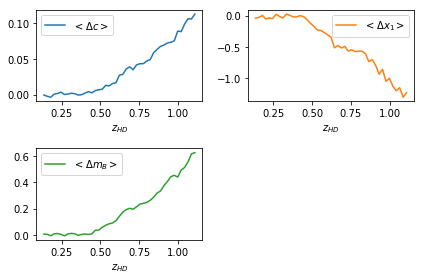

In [6]:
delta = (binned_snls_all[pars].mean() - binned_snls_cut[pars].mean())
error = (binned_snls_all[pars].std() - binned_snls_cut[pars].std()) / binned_snls_all[pars].count()

delta['zHD'] = bins[delta.index.values]

delta.columns = ['$< \\Delta c >$', '$< \\Delta x_1 >$', '$< \\Delta m_B>$', '$z_{HD}$'] # define labels for plotting

delta.plot(x='$z_{HD}$', yerr=error, 
           sharex=False,
           subplots=True, layout=(2, 2))

plt.tight_layout()
plt.show()

delta.columns = ['c', 'x1', 'mB', 'zHD'] # reset column labels

# plot single realization correction

In [7]:
sim_number = 8
data = pd.read_csv('/home/et3918/mlacceleration/SNe_samples/selected_{}.txt'.format(sim_number), sep='\s+')
data = data[['zCMB', 'zHD', 'c', 'x1', 'mB']]

In [8]:
adhoc_data = data.copy()
for par in ['c', 'x1', 'mB']:
    adhoc_data[par] += delta[par][np.digitize(adhoc_data['zHD'], bins)].values

In [9]:
concatted = pd.concat([data, adhoc_data], keys=['data', 'adhoc'])

In [10]:
def c_true(z):
    return -0.000320865

def x1_true(z):
    return 0.011789294

def mB_true(z):
    return bahamas.cosmology.muz([.3, -1, .7], z, z) + -19.365

true_values = {
    'c': c_true,
    'x1': x1_true,
    'mB': mB_true
}

In [11]:
mag_scale_factor = {
    'c': 3.2, # beta_true
    'x1': .14, # alpha_true
    'mB': 1
}

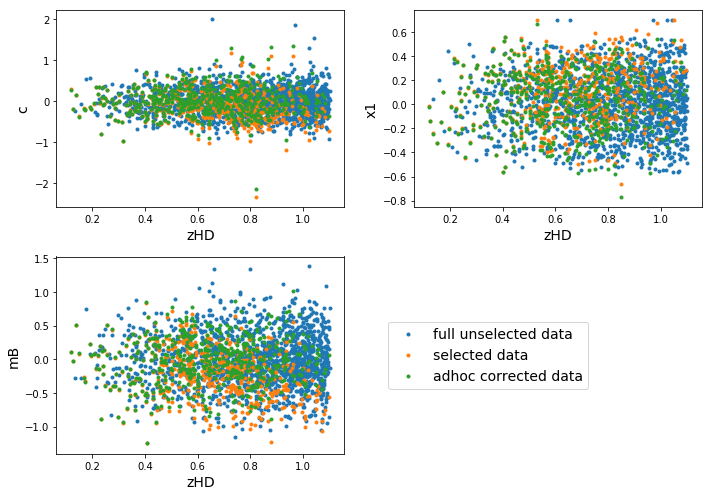

In [12]:
# take random points from the full dataset since there are too many of them
random_indices = list(np.random.randint(len(snls_all), size=1500))

fig = plt.figure(figsize=(10, 7))
for i, par in enumerate(['c', 'x1', 'mB']):
    plt.subplot(2, 2, i+1)
    full_plotted = plt.scatter(snls_all['zHD'][random_indices], 
                               mag_scale_factor[par]*(snls_all[par][random_indices] 
                                                      - true_values[par](snls_all['zHD'][random_indices])), 
                               marker='.')
    
    data_plotted = plt.scatter(data['zHD'], 
                               mag_scale_factor[par]*(data[par] 
                                                      - true_values[par](data['zHD'])), 
                               marker='.')
    
    adhoc_plotted = plt.scatter(adhoc_data['zHD'], 
                                mag_scale_factor[par]*(adhoc_data[par] 
                                                       - true_values[par](adhoc_data['zHD'])), 
                                marker='.')
    
    plt.xlabel('zHD', fontsize=14)
    plt.ylabel(par, fontsize=14)
    
plt.figlegend((full_plotted, data_plotted, adhoc_plotted), 
              ('full unselected data', 'selected data', 'adhoc corrected data'),
              fontsize=14,
              loc='center',
              bbox_to_anchor = (1.5,.5),
              bbox_transform=fig.axes[-1].transAxes)

plt.tight_layout()
plt.show()